In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from tsvd import *
from tecpsgd import *
from olstec import *
from stc import *

In [2]:
###############################################################################################################3

# datafile = np.load('/Users/kgilman/Desktop/WTD_upload/Toluene_200/L4array_10hz.npz')
datafile = np.load('/Users/kgilman/Desktop/WTD_upload/Toluene_200/L4array_5hz.npz')
# datafile = np.load('/Users/kgilman/Desktop/WTD_upload/Toluene_200/L4array_1hz.npz')

data_large = datafile['arr_0']
data_means = datafile['arr_1']
data_norms = datafile['arr_2']

###### Sample time in seconds ########
# sample_time = 0.1
sample_time = 0.2
# sample_time = 1

###### data is experiment x time x sensor #########

#### Data cleaning ####
data_large = data_large[:,1:,:]
data = np.delete(data_large,32,2)       # delete data from 33rd sensor--bad sensor
# data = np.delete(data,1103,1)
# data = np.delete(data,2012,1)
n1,n2,n3 = data.shape

# n2 = 100

num_sensors = int(np.floor(n3/10))

# for idx in range(0,num_sensors):
#     sensor = 10*idx + 10
#     plt.subplot(num_sensors,1,idx+1)
#     plt.plot(data_large[10,:,sensor])
# plt.show()

data = data[:,:n2,:]
X = Tensor(data)
# X = Tensor(np.transpose(data,[2,1,0]))
print(X.shape())
Xfrob = tfrobnorm(X)

print(np.max(X.array()))
print(np.min(X.array()))

#### t-SVD Analysis ####

tic = time.time()
U,S,V = tsvd(X,full=False)
toc = time.time()

S = np.diag(S.array()[:,:,0])
tElapsed = toc - tic
print('Time elapsed for tSVD: {:.3f}'.format(tElapsed))


#### Simulate missing entries by IID Bernoulli distribution ####
rho = 0.75  # percentage of missing entries
tube = False
np.random.seed(0)
if(tube is False):
    mask = np.random.rand(n1, n2, n3)
    mask[mask > rho] = 1
    mask[mask <= rho] = 0
    mask = mask.astype(int)
else:
    mask = np.random.rand(n1, n2)
    mask[mask > rho] = 1
    mask[mask <= rho] = 0
    mask = mask.astype(int)
    mask = np.repeat(mask[:, :, np.newaxis], n3, axis=2)

# mask = np.transpose(mask,[2,1,0])
Y = Tensor(X.array() * mask)
print(Y.shape())


(300, 1299, 70)
0.022790987878037322
-0.04075105223914733
Time elapsed for tSVD: 6.833
(300, 1299, 70)


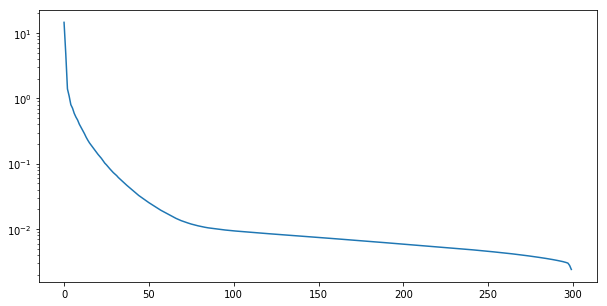

75% power rank: 6


In [3]:
plt.figure(figsize=(10,5))
plt.semilogy(S)
# plt.xticks(np.arange(0, min(n1,n2), step=20))
plt.rcParams.update({'font.size': 15})
plt.show()

total_sum = np.sum(S)
pwrs = np.cumsum(S) / total_sum
idx = np.where(pwrs < 0.75)
print('75% power rank: '+ np.str(idx[0][-1] + 1))


### TeCPSGD

In [4]:
## TeCPSGD
from tecpsgd import *
Tensor_Y_Noiseless = np.transpose(Y.array(),[0,2,1])
# rank = 75
rank = 30
OmegaTensor = np.transpose(mask,[0,2,1])
tensor_dims = [n1,n3,n2]
maxepochs = 1
tolcost = 1e-14
permute_on = False

options = {
    'maxepochs': maxepochs,
    'tolcost': tolcost,
    'lam': 0.0001,
    'stepsize': 100000,
    'permute_on':  permute_on,
    'store_subinfo': True,
    'store_matrix': False,
    'verbose': False
}

# options = {
#     'maxepochs': maxepochs,
#     'tolcost': tolcost,
#     'lam': 0.0,
#     'stepsize': 10000000,
#     'permute_on':  permute_on,
#     'store_subinfo': True,
#     'store_matrix': False,
#     'verbose': False
# }
np.random.seed(0)
Xinit = {
    'A': np.random.randn(tensor_dims[0], rank),
    'B': np.random.randn(tensor_dims[1], rank),
    'C': np.random.randn(tensor_dims[2], rank)
}

Xsol_TeCPSGD, Y_hat_tecpsgd, info_TeCPSGD, sub_infos_TeCPSGD = TeCPSGD(Tensor_Y_Noiseless, OmegaTensor, None, tensor_dims, rank,
                                                          Xinit, options)

A_t0 = Xsol_TeCPSGD['A']
B_t0 = Xsol_TeCPSGD['B']
C_t0 = Xsol_TeCPSGD['C']

# Y_hat_tecpsgd = np.zeros(Tensor_Y_Noiseless.shape)
# for f in range(0,n2):
#     gamma = C_t0[f,:].T
#     Y_hat_tecpsgd[:,:, f] = A_t0 @ np.diag(gamma) @ B_t0.T
    
Y_hat_tecpsgd = np.transpose(Y_hat_tecpsgd,[0,2,1])

nrmse_tecpsgd = tfrobnorm(Tensor(Y_hat_tecpsgd) - X) / Xfrob
tElapsed_tecpsgd = np.sum(sub_infos_TeCPSGD['times'])

print('TeCPSGD Time: {:4f}'.format(tElapsed_tecpsgd))
print('NRMSE TeCPSGD: {:6f}'.format(nrmse_tecpsgd))

TeCPSGD Time: 24.557278
NRMSE TeCPSGD: 0.138728


In [5]:
# s = np.diag(S.array()[:,:,0])
# power80 = 0.8*np.sum(s)

# cum_sum = 0
# k = 0
# for i in range(0,len(s)):
#     cum_sum += s[i]
#     k += 1
#     if(cum_sum > power80):
#         break

# print('Number of LR t-SVD Approx Components: {:.3f}'.format(k))

In [6]:
# # wind_sizes = [50, 100]
# wind_sizes = [50, 100, 200, 300, 400, 500, 1000]
# # wind_sizes = np.arange(5,500,20)
# plt.rcParams.update({'font.size': 22})
# fig,axs = plt.subplots(len(wind_sizes),1,figsize=(10,10),tight_layout=True)
# iter = 0
# for wind_size in wind_sizes:
#     num_blocks = int(np.floor(n2/wind_size))
#     num_comp = []

#     for w in range(0,num_blocks):
#         data = X.array()[:,wind_size*w:wind_size*w + wind_size,:]
#         U,S,V = tsvd(Tensor(data),full=False)
#         s = np.diag(S.array()[:,:,0])
#         power80 = 0.8*np.sum(s)
        
#         cum_sum = 0
#         k = 0
#         for i in range(0,len(s)):
#             cum_sum += s[i]
#             k += 1
#             if(cum_sum > power80):
#                 break
#         num_comp.append(k)

#     axs[iter].plot(np.arange(0,(num_blocks) * wind_size),np.repeat(num_comp,wind_size),label='%s' % wind_size)
# #     axs[iter].set_ylim([0, 10])
#     iter += 1
# fig.legend(loc='right', bbox_to_anchor=(1.2,0.5))
# plt.savefig('tubal-rank-windows_gasdata.eps')
# plt.show()
    

In [7]:
# diff = []
# bad = []
# for i in range(0,n2-1):
#     diff_val = (np.linalg.norm(X.array()[:,i,:] - X.array()[:,i+1,:]) / np.linalg.norm(X.array()[:,i,:]))
#     if(diff_val > 0.05):
#         bad.append(i)
#     diff.append(diff_val)

# plt.semilogy(np.arange(0,len(diff)),diff)
# plt.show()

# print(bad)

### STC

In [8]:
Tensor_Y = np.transpose(X.array(),[0,2,1])
Mask_Y = np.transpose(mask,[0,2,1])
numcycles = 1
outer = 1
r1 = 15
r2 = 15
r3 = 1
fun = lambda Lhat,idx: [0, tfrobnorm_array(Lhat[:,:,idx] - Tensor_Y[:,:,idx]) / tfrobnorm_array(Tensor_Y[:,:,idx])]
Lhat_stc, stats_stc, tElapsed = stc(Tensor_Y,Mask_Y,r1,r2,r3,outer,numcycles,fun=fun,verbose=False)

Lhat_stc = np.transpose(Lhat_stc,[0,2,1])

nrmse_stc = tfrobnorm(Tensor(Lhat_stc) - X) / Xfrob

print('STC Time: {:4f}'.format(tElapsed))
print('NRMSE STC: {:6f}'.format(nrmse_stc))

STC Time: 97.366519
NRMSE STC: 0.098112


### OLSTEC

In [9]:
## OLSTEC

Tensor_Y_Noiseless = np.transpose(X.array(),[0,2,1])
rank = 30
OmegaTensor = np.transpose(mask,[0,2,1])
tensor_dims = [n1,n3,n2]
maxepochs = 1
tolcost = 1e-14
permute_on = False

options = {
    'maxepochs': maxepochs,
    'tolcost': tolcost,
    'lam': 0.9,
    'mu': 1e-8,
    'permute_on':  permute_on,
    'store_subinfo': True,
    'store_matrix': False,
    'verbose': False,
    'tw_flag': None,
    'tw_len': None
}

# options = {
#     'maxepochs': maxepochs,
#     'tolcost': tolcost,
#     'lam': 1e-4,
#     'mu': 1e-8,
#     'permute_on':  permute_on,
#     'store_subinfo': True,
#     'store_matrix': False,
#     'verbose': False,
#     'tw_flag': None,
#     'tw_len': None
# }

np.random.seed(0)
Xinit = {
    'A': np.random.randn(tensor_dims[0], rank),
    'B': np.random.randn(tensor_dims[1], rank),
    'C': np.random.randn(tensor_dims[2], rank)
}

print(Tensor_Y_Noiseless.shape)
Xsol_olstec, Y_hat_olstec, info_olstec, sub_infos_olstec = OLSTEC(Tensor_Y_Noiseless, OmegaTensor, None, tensor_dims, rank,
                                                          Xinit, options)

A_t0 = Xsol_olstec['A']
B_t0 = Xsol_olstec['B']
C_t0 = Xsol_olstec['C']

# Y_hat_olstec = np.zeros(Tensor_Y_Noiseless.shape)
# for f in range(0,n2):
#     gamma = C_t0[f,:].T
#     Y_hat_olstec[:,:,f] = A_t0 @ np.diag(gamma) @ B_t0.T
    
Y_hat_olstec = np.transpose(Y_hat_olstec,[0,2,1])

nrmse_olstec = tfrobnorm(Tensor(Y_hat_olstec) - X) / Xfrob
tElapsed_olstec = np.sum(sub_infos_olstec['times'])

print('OLSTEC Time: {:4f}'.format(tElapsed_olstec))
print('NRMSE OLSTEC: {:6f}'.format(nrmse_olstec))


(300, 70, 1299)
OLSTEC Time: 194.305372
NRMSE OLSTEC: 0.293941


In [10]:
# ## TeCPSGD

# Tensor_Y_Noiseless = np.transpose(X.array(),[0,2,1])
# rank = 30
# OmegaTensor = np.transpose(mask,[0,2,1])
# tensor_dims = [n1,n3,n2]
# maxepochs = 1
# tolcost = 1e-14
# permute_on = False

# options = {
#     'maxepochs': maxepochs,
#     'tolcost': tolcost,
#     'lam': 0.001,
#     'stepsize': 0.1,
#     'mu': 0.05,
#     'permute_on':  permute_on,
#     'store_subinfo': True,
#     'store_matrix': False,
#     'verbose': True
# }

# Xinit = {
#     'A': np.random.randn(tensor_dims[0], rank),
#     'B': np.random.randn(tensor_dims[1], rank),
#     'C': np.random.randn(tensor_dims[2], rank)
# }

# Xsol_TeCPSGD, info_TeCPSGD, sub_infos_TeCPSGD = TeCPSGD(Tensor_Y_Noiseless, OmegaTensor, None, tensor_dims, rank,
#                                                           Xinit, options)

# A_t0 = Xsol_TeCPSGD['A']
# B_t0 = Xsol_TeCPSGD['B']
# C_t0 = Xsol_TeCPSGD['C']

# Y_hat_cp = np.zeros(Tensor_Y_Noiseless.shape)
# for f in range(0,n2):
#     gamma = C_t0[f,:].T
#     Y_hat_cp[:,:, f] = A_t0 @ np.diag(gamma) @ B_t0.T
    
# Y_hat_cp = np.transpose(Y_hat_cp,[0,2,1])

# nrmse_cp = tfrobnorm(Tensor(Y_hat_cp) - X) / Xfrob
# print('NRMSE CP: {:6f}'.format(nrmse_cp))

In [11]:
# nrmse_cp = tfrobnorm(Tensor(Y_hat_cp) - X) / Xfrob
# print('NRMSE CP: {:6f}'.format(nrmse_cp))

### TOUCAN

In [12]:
################################ TOUCAN #######################################
rank = 1
# fun = lambda L: [0, tfrobnorm(L - X) / Xfrob]
fun = lambda Q,k: [0, tfrobnorm_array(Q.array()[:,k,:] - X.array()[:,k,:]) / tfrobnorm_array(X.array()[:,k,:])]
# fun = lambda Q,k : [0,0]
Y_hat_toucan, U_toucan,stats_toucan, tElapsed_toucan = toucan(Y,mask,rank,tube=False,outer=1,cgtol=1e-6,mode='online',fun=fun,
                                                     randomOrder=False,verbose=False)
print('TOUCAN Time: {:4f}'.format(tElapsed_toucan))

TOUCAN Time: 14.835289


In [13]:
times_toucan = stats_toucan[1:,-1]
toucan_err = tfrobnorm(Y_hat_toucan - X) / Xfrob
print('NRMSE TOUCAN: {:6f}'.format(toucan_err))

NRMSE TOUCAN: 0.090254


### GROUSE

In [14]:
# Ym = lr_flatten(Y.array())
# mask_m = lr_flatten(mask)

# U,S,V = np.linalg.svd(Ym,full_matrices=False)
# plt.plot(S)
# plt.show()

# Lhat_grouse,stats,tElapsed = grouse(Ym,mask_m,1,1,mode='online',step=None)
# Lhat_grouse = np.reshape(Lhat_grouse,(n3,n1,n2))
# Lhat_grouse = Tensor(np.transpose(Lhat_grouse,(1,2,0)))


# grouse_err = tfrobnorm(Lhat_grouse - X) / Xfrob
# print('NRMSE GROUSE: {:6f}'.format(grouse_err))

# experiments = [0]
# sensors = [24, 30, 33, 34, 35, 37, 42, 44, 45]
# #### Plot tracking results ####
# for test in experiments:
#     fig, (ax1) = plt.subplots(figsize=(8,8), ncols=1, sharey=True, tight_layout=True)
#     for sensor in sensors:
#         ax1.plot(X.array()[test,100:200,sensor],label='$%i$'%sensor)
#         ax1.plot(Lhat_grouse.array()[test,100:200,sensor],label='$%i$'%sensor)
#         ax1.title.set_text('True')
    
#         ax1.scatter(np.arange(0,100),Y.array()[test,100:200,sensor], s=20,label='$%i$'%sensor)


#     fig.add_subplot(111, frameon=False)
#     plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
#     plt.grid(False)
#     plt.xlabel("Number of time slices")
# #     handles, labels = ax2.get_legend_handles_labels()
# #     plt.legend(handles, labels,title="Sensor #", loc='right', bbox_to_anchor=(1.2,0.5))
# #     fig.suptitle('Experiment %i'%test)
#     plt.rcParams.update({'font.size': 22})
#     name = 'gas_sensor_tracking-' + str(test)+ '-' + str(int(rho*100)) + '%'+'.eps'
# #     plt.savefig(name)
#     plt.show()

# # experiment_times = np.arange(0,n2*sample_time,sample_time)
# # for test in experiments:
# #     fig, (ax1, ax2) = plt.subplots(figsize=(15,10), ncols=2, sharey=True, sharex=True, tight_layout=True)
# #     for sensor in sensors:
# #         ax1.plot(experiment_times,X.array()[test,:,sensor]*data_norms[test] + data_means[test,sensor],
# #                  label='$%i$'%sensor)
# #         ax1.title.set_text('True')

# # #         times_toucan[times_toucan < 0.1] = 0.1
# #         ax2.plot(np.cumsum(times_toucan),Y_hat_toucan.array()[test,:,sensor]*data_norms[test] + data_means[test,sensor],
# #                  label='$%i$'%sensor )
# #         ax2.title.set_text('Predicted')

# #     fig.add_subplot(111, frameon=False)
# #     plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
# #     plt.grid(False)
# #     plt.xlabel("Time (s)")
# #     plt.rcParams.update({'font.size': 30})
# #     handles, labels = ax2.get_legend_handles_labels()
# #     plt.legend(handles, labels, title="Sensor #", loc='right', bbox_to_anchor=(1.25,0.5))
# # #     fig.suptitle('Experiment %i' % test)

# #     name = 'gas_sensor_tracking_time-' + str(test)+ '-' + str(int(rho*100)) + '%'+'.eps'
# # #     plt.savefig(name)
# #     plt.show()

### TNN-ADMM

In [15]:
# ## TNN-ADMM
fun = lambda L: [0,tfrobnorm(L - X) / Xfrob]
Y_hat_tnn,stats_tnn,tElapsed_tnn = lrtc(Y,mask,rho=1.5,niter = 75,min_iter=50,it_tol = 1e-4,fun=fun,verbose=True)
print('TNN Time: {:4f}'.format(tElapsed_tnn))

tnn_err = tfrobnorm(Y_hat_tnn - X) / Xfrob
print('NRMSE TNN-ADMM: {:6f}'.format(tnn_err))

Iter[0]: Cost fxn: 0.000, NRMSE: 1.000000 
Iter[10]: Cost fxn: 0.000, NRMSE: 1.000000 
Iter[20]: Cost fxn: 0.000, NRMSE: 0.313989 
Iter[30]: Cost fxn: 0.000, NRMSE: 0.040120 
Iter[40]: Cost fxn: 0.000, NRMSE: 0.032588 
Iter[50]: Cost fxn: 0.000, NRMSE: 0.032532 
TNN Time: 315.560041
NRMSE TNN-ADMM: 0.032532


### TCTF

In [18]:
## TCTF
rank = 7
fun = lambda U,V: [0, tfrobnorm(U*V - X) / Xfrob]
# fun = lambda U,V: [0,0]
Xtctf,Ztctf, stats_tctf, tElapsed_tctf = tctf(Y,mask,rank,niter = 75,min_iter = 50,it_tol = 1e-4,fun=fun,verbose=True)
Y_hat_tctf = Xtctf * Ztctf
print('TCTF Time: {:4f}'.format(tElapsed_tctf))

tctf_err = tfrobnorm(Y_hat_tctf - X) / Xfrob
print('NRMSE TCTF: {:6f}'.format(tctf_err))

Iter[1]: NRMSE: 0.603793 
Iter[11]: NRMSE: 0.168521 
Iter[21]: NRMSE: 0.093035 
Iter[31]: NRMSE: 0.076984 
Iter[41]: NRMSE: 0.075500 
Iter[51]: NRMSE: 0.075216 
TCTF Time: 247.115932
NRMSE TCTF: 0.075200


In [19]:
# L_m = lr_flatten(L.array())
# mask_m = lr_flatten(mask)

# Y_m = L_m * mask_m

# rank = 1
# fun = lambda X,k: [0, np.linalg.norm(X - L_m[:,k]) / np.linalg.norm(L_m[:,k])]
# Ym_hat_grouse, stats_grouse, tElapsed_grouse = grouse(Y_m, mask_m, rank,outer=1,mode="online",fun=fun,randomOrder=False,
#                                                       verbose=False)
# grouse_nrmse = np.linalg.norm(Ym_hat_grouse - R_m,'fro') / np.linalg.norm(R_m,'fro')
# print('GROUSE Time: {:4f}'.format(tElapsed_grouse))
# print('GROUSE NRMSE: {:4f}'.format(grouse_nrmse))
        
# nrmse_grouse = stats_grouse[:,1]
# times_grouse = stats_grouse[:,-1]
# tElapsed_grouse = np.sum(times_grouse)
# plt.semilogy(nrmse_grouse)
# plt.title('GROUSE: Recovered Tensor NRMSE')
# plt.xlabel('Iteration')
# plt.show()

### Compute error stats

/Users/kgilman/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


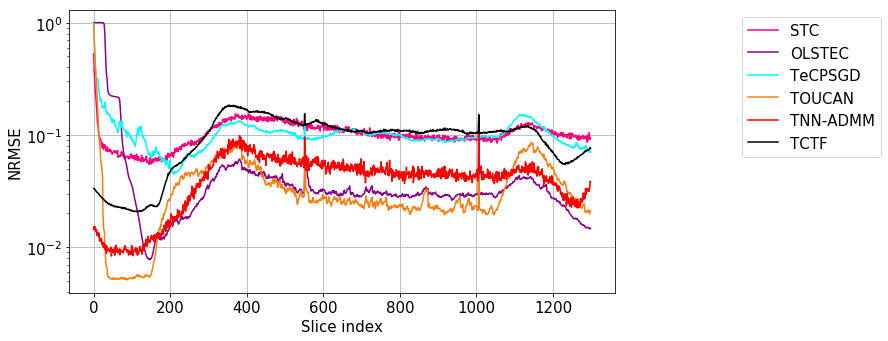

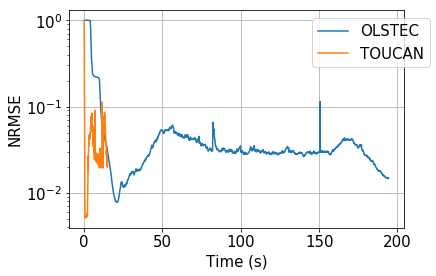

In [20]:
stc_frame_err = []
olstec_frame_err = []
toucan_frame_err = []
tnn_frame_err = []
tctf_frame_err = []
tecpsgd_frame_err = []

for i in range(0,n2):
    stc_frame_err.append(np.linalg.norm(Lhat_stc[:,i,:].squeeze() - X.array()[:,i,:]) / np.linalg.norm(X.array()[:,i,:]))
    olstec_frame_err.append(np.linalg.norm(Y_hat_olstec[:,i,:].squeeze() - X.array()[:,i,:]) / np.linalg.norm(X.array()[:,i,:]))
    tecpsgd_frame_err.append(np.linalg.norm(Y_hat_tecpsgd[:,i,:].squeeze() - X.array()[:,i,:]) / np.linalg.norm(X.array()[:,i,:]))
    toucan_frame_err.append(np.linalg.norm(Y_hat_toucan.array()[:,i,:].squeeze() - X.array()[:,i,:]) / np.linalg.norm(X.array()[:,i,:]))
    tnn_frame_err.append(np.linalg.norm(Y_hat_tnn.array()[:,i,:] - X.array()[:,i,:]) / np.linalg.norm(X.array()[:,i,:]))
    tctf_frame_err.append(np.linalg.norm(Y_hat_tctf.array()[:,i,:] - X.array()[:,i,:]) / np.linalg.norm(X.array()[:,i,:]))
    

plt.figure(figsize=(13,5),tight_layout=True)
plt.semilogy(np.arange(0,len(stc_frame_err)), stc_frame_err,'#FF007F',label='STC')
plt.semilogy(np.arange(0,len(olstec_frame_err)),olstec_frame_err,'#8B008B',label='OLSTEC')
plt.semilogy(np.arange(0,len(tecpsgd_frame_err)),tecpsgd_frame_err,'#00FFFF',label='TeCPSGD')
plt.semilogy(np.arange(0,len(toucan_frame_err)),toucan_frame_err,'#ff7f0e', label='TOUCAN')
plt.semilogy(np.arange(0,len(tnn_frame_err)),tnn_frame_err,'r',label='TNN-ADMM')
plt.semilogy(np.arange(0,len(tctf_frame_err)),tctf_frame_err,'k',label='TCTF')
plt.legend(bbox_to_anchor=(1.5,1))
plt.xlabel('Slice index')
plt.ylabel('NRMSE')
plt.grid()
name = '/Users/kgilman/Desktop/t-SVD/gas_frame_NRMSE_tube_' + np.str(tube) + '_' + np.str(rho*100) + 'p.eps'
plt.savefig(name)
plt.show()

plt.semilogy(np.cumsum(sub_infos_olstec['times'][1:]),sub_infos_olstec['err_residual'][1:],
    np.cumsum(stats_toucan[:,-1]),stats_toucan[:,1]
)

plt.legend(('OLSTEC', 'TOUCAN'),bbox_to_anchor=(1.1, 1 ))
plt.xlabel('Time (s)')
plt.ylabel('NRMSE')
plt.grid()
plt.rcParams.update({'font.size': 22})
# plt.savefig('gas_sensor_frame_nrmse_' + str(rho*100) + 'p.eps')
plt.show()

In [ ]:
###### Select experiments and sensors to plot results over #####

# experiments = [0, 100, 150, 200, 250, 299]
experiments = [100]
# np.random.seed(0)
# experiments = np.random.choice(299,5,replace=False)
# sensors = np.arange(0,n3,5)
# sensors = [30, 33, 34, 35, 37, 42, 44, 45]
sensors = [34]

In [ ]:
#### Plot tracking results ####
start = 1000
stop = start + 300

test = 100
sensor = 34

idx = np.where(Y.array()[test,start:stop,sensor].squeeze() > 0)[0]
idx = idx + start
        
fig, a = plt.subplots(2, 3,figsize=(20,10),sharex=True,sharey=True)

for i in range(0,2):
    for j in range(0,3):
        a[i,j].plot(np.arange(start,stop),X.array()[test,start:stop,sensor],label='$%i$'%sensor)
        a[i,j].scatter(idx,Y.array()[test,idx,sensor], s=20)

a[0,0].plot(np.arange(start,stop),Y_hat_toucan.array()[test,start:stop,sensor],label='$%i$'%sensor)
a[0,0].title.set_text('TOUCAN')

a[0,1].plot(np.arange(start,stop),Y_hat_tecpsgd[test,start:stop,sensor],label='$%i$'%sensor)
a[0,1].title.set_text('TeCPSGD')

a[0,2].plot(np.arange(start,stop),Y_hat_olstec[test,start:stop,sensor],label='$%i$'%sensor)
a[0,2].title.set_text('OLSTEC')

a[1,0].plot(np.arange(start,stop),Lhat_stc[test,start:stop,sensor],label='$%i$'%sensor)
a[1,0].title.set_text('STC')

a[1,1].plot(np.arange(start,stop),Y_hat_tnn.array()[test,start:stop,sensor],label='$%i$'%sensor)
a[1,1].title.set_text('TNN-ADMM')

a[1,2].plot(np.arange(start,stop),Y_hat_tctf.array()[test,start:stop,sensor],label='$%i$'%sensor)
a[1,2].title.set_text('TCTF')

# Set common labels
fig.text(0.5, 0.04, 'Sensor value', ha='center', va='center')
fig.text(0.06, 0.5, 'Time sample', ha='center', va='center', rotation='vertical')

name = '/Users/kgilman/Desktop/t-SVD/gas_sensor_traces_tube_' + np.str(tube) + '_' + np.str(rho*100) + 'p.eps'
# plt.savefig(name)